In [ ]:
%run D:\codes\confg
%run D:\codes\ukmo\read_ukmo.ipynb
%run D:/codes/icon/read_icon_model_3D.ipynb
%run D:/codes/icon/read_icon2TE_model_3D.ipynb
%run D:/codes/wrf_helen/wrf_zeitreihe.ipynb
%run D:/codes/icon/icons_zeitreihe.ipynb
%run D:/codes/HATPRO/zeitreihe_hatpro.ipynb
%run D:/codes/HOBOs/hobos_read_in.ipynb
%run D:/codes/icon/icons_zeitreihe-Copy1.ipynb

In [32]:
%%capture
import warnings
import glob
import os
import pandas as pd
import xarray as xr
import metpy
import metpy.calc as mpcalc
import numpy as np
import pandas as pd
import wrf
from matplotlib import pyplot as plt
from metpy.units import units
from netCDF4 import Dataset
    
warnings.filterwarnings("ignore")

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

# AROME

In [2]:
def read_2D_variables_AROME(variableList, lon, lat, slice_lat_lon=False):
    """ WITH the sel Method
    Read all the 2D variables (single netcdf per variable) and merge them

    :param variableList: List of the selected variables
    :param lon: Longitude of the MOMAA station
    :param lat: Latitude of the MOMAA station
    :param slice_lat_lon: Method for selecting latitude and longitude ('nearest' for nearest neighbor, None for exact match)
    :return: Merged DataFrame with all the variables
    """
    datasets = []  # List to hold the interpolated datasets for each variable

    for variable in variableList:
        file_path = os.path.join(dir_2D_AROME, f"AROME_Geosphere_20171015T1200Z_CAP02_2D_30min_1km_best_{variable}.nc")

        ds = xr.open_dataset(file_path)

        # Use no method if lat or lon are slice objects
        if slice_lat_lon:
            ds = ds.sel(longitude=lon, latitude=lat).isel(time=slice(4, None))
        else:
            ds = ds.sel(longitude=lon, latitude=lat, method="nearest").isel(time=slice(4, None))

        for var, units in variables_units_2D_AROME.items():
            if var in ds:
                ds[var].attrs['units'] = units

        ds_quantified = ds.metpy.quantify()
        datasets.append(ds_quantified)

    return xr.merge(datasets, join="exact")

In [3]:
def read_3D_variables_AROME(variables, method, lon, lat, slice_lat_lon=False, level=None, time=None):
    """
    Merge datasets for a list of variables at a specific location and time.
    The (lat, lon, time) parameters can also be arrays, e.g., [10, 12, 13].

    :param variables: List of variable names to include in the final merged dataset.
    :param method: Selection method ('sel' or 'interp') for data points.
    :param level: optional nz coordinate for data selection.
    :param lon: Longitude coordinate for data selection.
    :param lat: Latitude coordinate for data selection.
    :param time: Optional time (is set from 4 to None) assuming it starts at 12:00
    :param slice_lat_lon: default False, says if it is a slice object or not
    :return: Merged xarray Dataset for the specified variables, location, and time.
    """
    datasets = []  # List to hold datasets for each variable

    for var in variables:
        # Construct the file path and open the dataset
        file_path = os.path.join(dir_3D_AROME, f"AROME_Geosphere_20171015T1200Z_CAP02_3D_30min_1km_best_{var}.nc")
        ds = xr.open_dataset(file_path)

        if time is None:
            time_start = pd.to_datetime('2017-10-15 14:00:00',
                                        format='%Y-%m-%d %H:%M:%S')
            time_end = pd.to_datetime('2017-10-16 12:00:00',
                                      format='%Y-%m-%d %H:%M:%S')
            time = pd.date_range(start=time_start, end=time_end, freq='30min')

        # Select or interpolate the dataset based on the method
        ds_selected = ds.isel(x=398, y=215)
            
        # Update variable units
        for variable, units in variables_units_3D_AROME.items():
            if variable in ds_selected:
                ds_selected[variable].attrs['units'] = units

        # Quantify the dataset and append to the list
        datasets.append(ds_selected.metpy.quantify())

    # Merge all datasets
    return xr.merge(datasets, join="exact")

In [4]:
def read_timeSeries_AROME(location):
    """The Timeseries is a direct AROME model output which holds all variables (see Data_structure.md) for a specific
    location
    ::param location: is the selected location
    """
    pattern = f"AROME_Geosphere_20171015T1200Z_{location}_timeseries_40s_*.nc"
    final_path_pattern = os.path.join(dir_timeseries_AROME, pattern)
    # Use glob to find files that match the pattern
    matching_files = glob.glob(final_path_pattern)

    # Assuming there's only one match per location, open the dataset
    if matching_files:
        return xr.open_dataset(matching_files[0])
    else:
        raise FileNotFoundError(f"No files found for location {location}")

In [5]:
def read_in_arome(time, method, lon, lat):
    my_variable_list = ["p", "q", "th", "u", "v", "z"]

    if (method == "sel") | (method == "interp"):
        print(f"Your selected method is {method}")
    else:
        raise AttributeError(
            "You have to define a method (sel or interp) how the point near the LOWI should be selected")

    df_final = read_3D_variables_AROME(variables=my_variable_list, method=method, lon=lon, lat=lat, time=time)
    return df_final

In [6]:
def read_in_arome(time, method, lon, lat):
    """plot the MODEL output of AROME as it would be a Radiosonde"""
    my_variable_list = ["p", "q", "th", "u", "v", "z"]

    if (method == "sel") | (method == "interp"):
        print(f"Your selected method is {method}")
    else:
        raise AttributeError(
            "You have to define a method (sel or interp) how the point near the LOWI should be selected")

    df_final = read_3D_variables_AROME(variables=my_variable_list, method=method, lon=lon, lat=lat, time=time)

    print(df_final["p"].metpy.unit_array.magnitude) 
    #Extract values
    df_final["temperature"] = metpy.calc.temperature_from_potential_temperature(df_final["p"], df_final["th"])
    p = df_final["p"].metpy.unit_array.to(units.hPa)  # Metadata is removed
    T = df_final["temperature"].metpy.unit_array.to(units.degC)

    ds = xr.Dataset()

    return df_final

In [7]:
arome = read_in_arome(time=all, method='sel', lon=11.384167, lat=47.259998)
arome

Your selected method is sel
[[  604.0626  3191.4956  4343.409  ... 95455.516  95593.64   95715.29  ]
 [  604.0626  3191.4956  4343.409  ... 95091.37   95229.04   95350.164 ]
 [  604.0626  3191.4956  4343.409  ... 95056.92   95194.586  95316.7   ]
 ...
 [  604.0626  3191.4956  4343.409  ... 95159.84   95297.56   95418.734 ]
 [  604.0626  3191.4956  4343.409  ... 95141.25   95278.97   95400.14  ]
 [  604.0626  3191.4956  4343.409  ... 95114.16   95251.875  95373.04  ]]


Magnitude,[[604.0626220703125 3191.49560546875 4343.4091796875 ... 95455.515625 95593.640625 95715.2890625] [604.0626220703125 3191.49560546875 4343.4091796875 ... 95091.3671875 95229.0390625 95350.1640625] [604.0626220703125 3191.49560546875 4343.4091796875 ... 95056.921875 95194.5859375 95316.703125] ... [604.0626220703125 3191.49560546875 4343.4091796875 ... 95159.84375 95297.5625 95418.734375] [604.0626220703125 3191.49560546875 4343.4091796875 ... 95141.25 95278.96875 95400.140625] [604.0626220703125 3191.49560546875 4343.4091796875 ... 95114.15625 95251.875 95373.0390625]]
Units,pascal
Magnitude,[11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836 11.385000228881836]
Units,dimensionless
Magnitude,[47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234 47.255001068115234]
Units,dimensionless
Magnitude,[[1.0 2.0 3.0 ... 88.0 89.0 90.0] [1.0 2.0 3.0 ... 88.0 89.0 90.0] [1.0 2.0 3.0 ... 88.0 89.0 90.0] ... [1.0 2.0 3.0 ... 88.0 89.0 90.0] [1.0 2.0 3.0 ... 88.0 89.0 90.0] [1.0 2.0 3.0 ... 88.0 89.0 90.0]]
Units,dimensionless
Magnitude,[[3.0404235076275654e-06 3.0727069315616973e-06 2.928372850874439e-06 ... 0.006671760696917772 0.006748444400727749 0.006805440876632929] [3.0494265956804156e-06 3.0576347853639163e-06 2.925552507804241e-06 ... 0.006631912663578987 0.006741492077708244 0.006907403469085693] [3.076945176871959e-06 3.0530272852047347e-06 2.9287866709637456e-06 ... 0.00695790583267808 0.007126571610569954 0.007360541261732578] ... [3.474100594758056e-06 3.053394721064251e-06 2.941465936601162e-06 ... 0.005044637713581324 0.005119511391967535 0.005290281027555466] [3.43013925885316e-06 3.0473438528133556e-06 2.942775608971715e-06 ... 0.005125368945300579 0.005202587693929672 0.00537567725405097] [3.3971764423768036e-06 3.0553756005247124e-06 2.945198502857238e-06 ... 0.0052278973162174225 0.005316484719514847 0.0054981401190161705]]
Units,dimensionless
Magnitude,[[991.3232421875 565.8681640625 514.617431640625 ... 301.84521484375 301.980224609375 302.044189453125] [988.3369140625 565.124755859375 512.337890625 ... 301.58935546875 301.619140625 301.66162109375] [991.366943359375 567.087890625 513.343505859375 ... 301.535888671875 301.591064453125 301.69189453125] ... [983.1962890625 569.9580078125 513.036865234375 ... 296.92016601562

In [8]:
#max
temp = np.zeros(len(arome.temperature))
for i in range(len(arome.temperature)):
    temp[i] = (arome.temperature[i][76].values)
temp.size
#Hafelekar
temp_seg = np.zeros(len(arome.temperature))
for i in range(len(arome.temperature)):
    temp_seg[i] = (arome.temperature[i][52].values)
temp_seg

array([285.03085327, 285.12185669, 285.12112427, 285.09042358,
       285.03567505, 285.08084106, 284.9708252 , 284.94039917,
       284.9755249 , 284.88336182, 284.80014038, 284.71435547,
       284.69403076, 284.69351196, 284.69952393, 284.68304443,
       284.69091797, 284.71881104, 284.69650269, 284.7059021 ,
       284.67077637, 284.59768677, 284.49545288, 284.40930176,
       284.36221313, 284.30548096, 284.2305603 , 284.18081665,
       284.15328979, 284.11764526, 284.07116699, 284.03100586,
       283.99575806, 283.98825073, 284.00769043, 284.03689575,
       284.12121582, 284.27828979, 284.38873291, 284.45651245,
       284.52471924, 284.62130737, 284.75177002, 284.84036255,
       284.94241333, 284.98477173, 285.06460571, 285.15353394,
       285.18057251])

# UM

In [13]:
def get_ukmo_level(city_name=None, lat=None, lon=None):
    """read in UKMO Model at a fixed point and select the lowest level, either with city_name or with (lat, lon)"""
    if city_name is not None:
        lat, lon = get_coordinates_by_station_name(city_name)

    xi, yi = get_rotated_index_of_lat_lon(latitude=lat, longitude=lon)

    df = pd.DataFrame()
    for var in ["u", "v", "w", "z", "th", "q", "p"]:
        data = xr.open_dataset(f"{ukmo_folder}/MetUM_MetOffice_20171015T1200Z_CAP02_3D_30min_1km_optimal_{var}.nc")
        dat = data.sel(time=slice("2017-10-15T14:00:00", "2017-10-16T12:00:00.000000000"))
        
        #HERE CHANGE FOR OTHER LEVELS
        data_final = dat.isel(grid_latitude=yi, grid_longitude=xi, model_level_number=5, bnds=1) 

        # print(data_final["level_height"].values) # u and v are on 2.5 m, all other variables at 5m

        if var == "v":
            df["transformed_y_wind"] = data_final["transformed_y_wind"]
            df.set_index(data_final["time"].values, inplace=True)

        elif var == "u":
            df["transformed_x_wind"] = data_final["transformed_x_wind"]

        elif var == "w":
            df["upward_air_velocity"] = data_final["upward_air_velocity"]
        elif var == "z":
            df["geopotential_height"] = data_final["geopotential_height"]
        elif var == "th":
            df["air_potential_temperature"] = data_final["air_potential_temperature"]
        elif var == "q":
            df["specific_humidity"] = data_final["specific_humidity"]
        elif var == "p":
            df["air_pressure"] = data_final["air_pressure"]

    # convert variables
    temp_pot = df["air_potential_temperature"].values * units("K")
    pres = df["air_pressure"].values * units("Pa")

    df["temperature"] = mpcalc.temperature_from_potential_temperature(pres,
                                                                      temp_pot).magnitude - 273.15  # convert it to celsius

    df["specific_humidity"] = df["specific_humidity"] * 1000  # from kg / kg in g/kg
    u_icon = df["transformed_x_wind"].values * units("m/s")
    v_icon = df["transformed_y_wind"].values * units("m/s")

    df["wind_dir"] = mpcalc.wind_direction(u_icon, v_icon, convention='from')
    df["windspeed"] = mpcalc.wind_speed(u_icon, v_icon)

    temp_C = df["temperature"].values * units("degC")

    specific_humidity = df["specific_humidity"].values * units("g/kg")

    df["relative_humidity"] = mpcalc.relative_humidity_from_specific_humidity(pres.to(units.hPa), temp_C.to(units.K),
                                                                              specific_humidity).to("percent")
    return df

In [14]:
def get_ukmo_level_haf(city_name=None, lat=None, lon=None):
    """read in UKMO Model at a fixed point and select the lowest level, either with city_name or with (lat, lon)"""
    if city_name is not None:
        lat, lon = get_coordinates_by_station_name(city_name)

    xi, yi = get_rotated_index_of_lat_lon(latitude=lat, longitude=lon)

    df = pd.DataFrame()
    for var in ["u", "v", "w", "z", "th", "q", "p"]:
        data = xr.open_dataset(f"{ukmo_folder}/MetUM_MetOffice_20171015T1200Z_CAP02_3D_30min_1km_optimal_{var}.nc")
        dat = data.sel(time=slice("2017-10-15T14:00:00", "2017-10-16T12:00:00.000000000"))
        
        #HERE CHANGE FOR OTHER LEVELS
        data_final = dat.isel(grid_latitude=yi, grid_longitude=xi, model_level_number=21, bnds=1) 

        # print(data_final["level_height"].values) # u and v are on 2.5 m, all other variables at 5m

        if var == "v":
            df["transformed_y_wind"] = data_final["transformed_y_wind"]
            df.set_index(data_final["time"].values, inplace=True)

        elif var == "u":
            df["transformed_x_wind"] = data_final["transformed_x_wind"]

        elif var == "w":
            df["upward_air_velocity"] = data_final["upward_air_velocity"]
        elif var == "z":
            df["geopotential_height"] = data_final["geopotential_height"]
        elif var == "th":
            df["air_potential_temperature"] = data_final["air_potential_temperature"]
        elif var == "q":
            df["specific_humidity"] = data_final["specific_humidity"]
        elif var == "p":
            df["air_pressure"] = data_final["air_pressure"]

    # convert variables
    temp_pot = df["air_potential_temperature"].values * units("K")
    pres = df["air_pressure"].values * units("Pa")

    df["temperature"] = mpcalc.temperature_from_potential_temperature(pres,
                                                                      temp_pot).magnitude - 273.15  # convert it to celsius

    df["specific_humidity"] = df["specific_humidity"] * 1000  # from kg / kg in g/kg
    u_icon = df["transformed_x_wind"].values * units("m/s")
    v_icon = df["transformed_y_wind"].values * units("m/s")

    df["wind_dir"] = mpcalc.wind_direction(u_icon, v_icon, convention='from')
    df["windspeed"] = mpcalc.wind_speed(u_icon, v_icon)

    temp_C = df["temperature"].values * units("degC")

    specific_humidity = df["specific_humidity"].values * units("g/kg")

    df["relative_humidity"] = mpcalc.relative_humidity_from_specific_humidity(pres.to(units.hPa), temp_C.to(units.K),
                                                                              specific_humidity).to("percent")
    return df

In [15]:
um_lowest_level = get_ukmo_level(lat=47.2598, lon=11.3553) #LOWI
um_seg = get_ukmo_level_haf(lat=47.2598, lon=11.3553) #LOWI
um_lowest_level

,transformed_x_wind,transformed_y_wind,upward_air_velocity,geopotential_height,air_potential_temperature,specific_humidity,air_pressure,temperature,wind_dir,windspeed,relative_humidity
2017-10-15 14:00:00,0.562470,0.437791,0.037109,745.375,296.625,5.032063,94053.375,18.324432,232.105072,0.712764,35.518475
2017-10-15 14:30:00,-0.374936,-0.125195,0.012695,745.375,297.000,5.237401,94046.625,18.686920,71.535316,0.395286,36.123192
2017-10-15 15:00:00,-0.687952,-0.250358,-0.069336,745.375,297.250,5.332053,94047.750,18.933563,70.002678,0.732091,36.203869
2017-10-15 15:30:00,-0.750159,0.312108,0.070312,745.375,297.500,5.370378,94055.125,19.185760,112.590050,0.812497,35.885326
2017-10-15 16:00:00,-0.625482,0.187170,0.026367,745.375,297.375,5.573988,94081.625,19.086456,106.659340,0.652886,37.501385
2017-10-15 16:30:00,-0.625869,0.187173,-0.040039,745.375,297.375,5.616248,94105.375,19.107544,106.649879,0.653257,37.746185
2017-10-15 17:00:00,-0.812466,0.312076,-0.020508,745.375,297.625,5.508482,94119.625,19.365906,111.012260,0.870340,36.417969
2017-10-15 17:30:00,-1.312434,0.249318,0.013672,745.375,297.250,5.581737,94135.750,19.011627,100.756081,1.335905,37.756077
2017-10-15 18:00:00,-1.062434,0.249448,-0.015625,745.375,297.000,5.502760,94150.125,18.778656,103.213089,1.091325,37.783688
2017-10-15 18:30:00,-1.312338,0.061819,-0.000977,745.375,297.000,5.388975,94156.000,18.783844,92.696999,1.313794,36.988247


In [19]:
datetime_range = pd.date_range(start='2017-10-15 12:00', end='2017-10-16 11:00', freq='H')


# PLOTS

In [23]:
#hobo_zeitreihe = [station_data['ta'] for station_data in read_in_hobos(loc, my_time=datetime_range).values()]

In [24]:
datetime_range_hobo = pd.date_range(start='2017-10-15 14:00', end='2017-10-16 12:00', freq='H')

AttributeError: module 'wrf' has no attribute 'time'

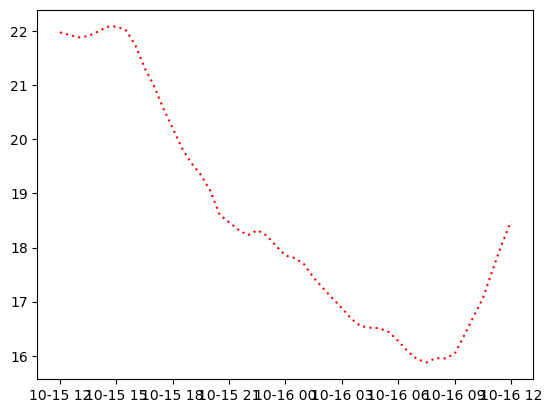

In [25]:
#MAX


plt.plot(arome.time, temp-273.15, c='r', label='AROME', ls=(0, (1, 2)))
plt.plot(wrf.time, temp_wrf, c='b', label='WRF', ls=(0, (5, 2)))
plt.plot(um_lowest_level.index, um_lowest_level.temperature, c='g', label='UM', ls=(0, (5, 2, 1, 2)))
plt.plot(datetime_range, icon, c='orange', label='ICON', ls=(0, (5, 2, 1, 2, 1, 2)))
plt.plot(datetime_range, icon2TE, c='m', label='ICON2TE', ls=(0, (5, 2, 5, 2, 1, 2)))
plt.plot(hatpro_selected_time.rawdate, hatpro_selected_time.T[13], c='tab:blue', label='HATPRO', lw=4)
plt.plot(datetime_range_hobo, hobo_zeitreihe[2], c='y', label='HOBO', lw=4)
plt.vlines(x=sunset, ymin=9, ymax=24, color='k', lw=2, ls='-')
plt.vlines(x=sunrise, ymin=9, ymax=19, color='k', lw=2, ls='-')
plt.text(sunset - pd.Timedelta(hours=1), 24.5, 'Sunset')
plt.text(sunrise - pd.Timedelta(hours=1), 19.5, 'Sunrise')
plt.ylim(9,26)
plt.xticks(rotation=30)
plt.xlabel('Time (UTC)')
plt.ylabel('$T$ (°C)')
plt.legend()
#plt.text(sunrise + pd.Timedelta(hours=4), 25, r'$z_{max}$', fontsize=16)
plt.tight_layout()
plt.grid()
plt.savefig("D:/plots/zeitreihe_max.svg")

In [ ]:
model = ['HATPRO', 'HOBO', 'WRF','AROME','UM','ICON','ICON2TE']
np.round(pd.DataFrame({'model': model,
                      'T_min': [min(hatpro_selected_time.T[13]).values.item(), min(hobo_zeitreihe[2]), min(temp_wrf), 
                            min(temp-273.15), min(um_lowest_level.temperature), min(icon), min(icon2TE)]
                        }).set_index('model'),2)

In [ ]:
np.mean([min(temp-273.15),
min(temp_wrf),
min(um_lowest_level.temperature),
min(icon),
min(icon2TE)])

In [ ]:
np.mean([min(hatpro_selected_time.T[13]).values.item(), min(hobo_zeitreihe[2])])

In [ ]:
sunset = pd.to_datetime('2017-10-15 16:25:00') #lt schöni in UTC
sunrise = pd.to_datetime('2017-10-16 5:37:00')

In [ ]:
plt.plot(arome.time, temp_seg-273.15, c='r', label='AROME', ls=(0, (1, 2)))
plt.plot(wrf.time, temp_wrf_seg, c='b', label='WRF', ls=(0, (5, 2)))
plt.plot(um_lowest_level.index, um_seg.temperature, c='g', label='UM', ls=(0, (5, 2, 1, 2)))
plt.plot(datetime_range, icon_seg, c='orange', label='ICON', ls=(0, (5, 2, 1, 2, 1, 2)))
plt.plot(datetime_range, icon2TE_seg, c='m', label='ICON2TE', ls=(0, (5, 2, 5, 2, 1, 2)))
plt.plot(hatpro_selected_time.rawdate, hatpro_selected_time.T[22], c='tab:blue', label='HATPRO', lw=4)
plt.plot(datetime_range_hobo, hobo_zeitreihe[0], c='y', label='HOBO', lw=4)
plt.vlines(x=sunset, ymin=5.5, ymax=15, color='k', lw=2, ls='-')
plt.vlines(x=sunrise, ymin=5.5, ymax=13, color='k', lw=2, ls='-')
plt.text(sunset - pd.Timedelta(hours=1), 15.25, 'Sunset')
plt.text(sunrise - pd.Timedelta(hours=1), 13.25, 'Sunrise')
plt.ylim(7,16.5)
#plt.vlines(x=pd.to_datetime('2017-10-16 3:00:00'), ymin=5.5, ymax=13, color='k', lw=2, ls='-')

plt.xticks(rotation=30)
plt.xlabel('Time (UTC)')
plt.ylabel('$T$ (°C)')
plt.legend()
plt.tight_layout()
plt.grid()
plt.savefig("D:/plots/zeitreihe_hafelekar.svg")